In [27]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import math
import os

**The reading of the dataset**

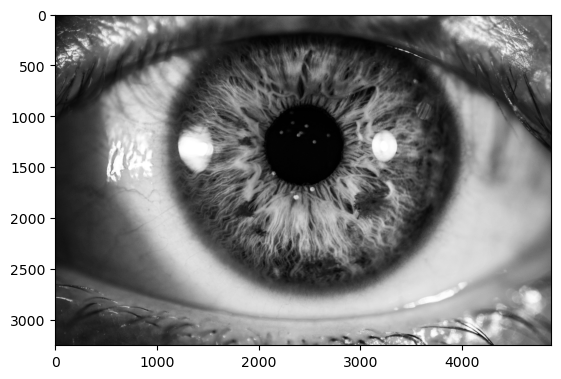

In [28]:
# Only one example image is taken from each subclass as testing on every example would be time-consuming.
def get_first_image_from_subdirectories(root_dir):
    # This method fills the "images" list by reading the first image from each folder.
    images = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith('.jpg'):
                img_path = os.path.join(dirpath, filename)
                img = io.imread(img_path, as_gray=True)
                if img is not None:
                    images.append(img)
                    break
    return images


# UBIRIS iris database path
dataset_path = "C:/Users/berse/OneDrive/Documents/GitHub/ENCM509-Project/daugman_iris_detection-main/data"
images = get_first_image_from_subdirectories(dataset_path)
plt.imshow(images[0], cmap='gray')

**The definition of operators**

In [29]:
import cv2 as cv
import numpy as np

def daugman_operator(gray_img, center, r_min, r_max, step):
    circle_areas = []
    mask = np.zeros(gray_img.shape, dtype=np.uint8)  # Use shape of gray_img for mask
    x, y = center
    
    rads = range(r_min, r_max, step)
    for r in rads:
        # Masking should be applied for calculating the area of the circle in the image.
        cv.circle(mask, center, r, 255, 1)
        circle_img = cv.bitwise_and(gray_img, gray_img, mask=mask)  # Use mask parameter
        circle_areas.append(np.sum(circle_img) / (2 * np.pi * r))
        # The mask is reset/cleared.
        mask.fill(0)
    
    max_area = max(circle_areas)
    max_index = circle_areas.index(max_area)
    radius = r_min + max_index * step
    return max_area, radius

In [30]:
def iris_segmentation(gray_img: np.ndarray, search_region: tuple = ((),()), r_min: int = 35, r_max: int = 60, center_step_size: int = 1):
    
    """ This function uses the Daugman Operator to detect the boundaries of the iris and pupil.
       
        gray_img: input grayscale image
        search_region: The search region size of the circle centers is defined by the top-left corner (x0, y0) and bottom-right corner (x1, y1).
        r_min: The minimum value of the circle radius for iteration.
        r_max: The maximum value of the circle radius for iteration.
        center_step_size: The distance between circles with the same center.
    """
  
    (x0, y0), (x1, y1) = search_region
    x_axis_points = list(range(x0, x1, center_step_size))
    y_axis_points = list(range(y0, y1, center_step_size))
    
    area_list = []
    coords = []

    for y in y_axis_points:
        for x in x_axis_points:
            area, rad = daugman_operator(gray_img, (x,y), r_min, r_max, 1)
            area_list.append(area)
            coords.append(((x,y), rad))

    best_iris_id = area_list.index(max(area_list))
    return coords[best_iris_id]

**The potential scanning area where the center of the eye can be found**

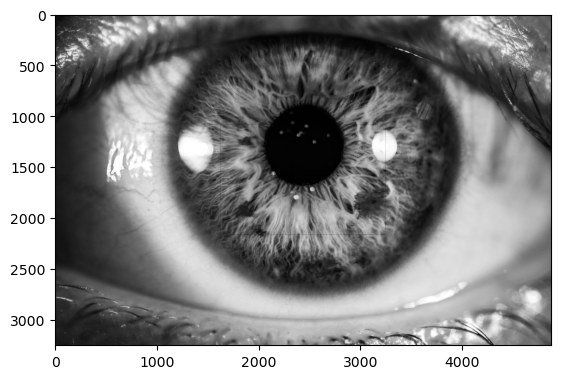

In [31]:
# It is assumed that each image has the same dimensions.
h, w = images[0].shape

# The potential search area where the eye center can be found is calculated as one-ninth (1/9) of the image dimensions.
start_point = int(w/3), int(h/3)
end_point = 2 * int(w/3), 2 * int(h/3)

region_img = images[0].copy()
cv.rectangle(region_img, start_point, end_point, (0,0,255), thickness=1)
plt.imshow(region_img, cmap='gray')

**Observation of the results**

In [ ]:
# Results are observed for a total of 241 different images by taking one image from each folder in the SESSAO_1 dataset.

# total_img = len(images)
total_img = 1
i_step = 20
plot_cols = 5

print("Processing... ")

for step in range(0, total_img, i_step):
    fig, axs = plt.subplots(i_step // plot_cols, plot_cols, figsize=(15, 10))
    axs = axs.ravel()

    for i, image in enumerate(images[step: step + i_step]):
        print(f"{i + step + 1}/{total_img}", end="\r")

        result_img = image.copy()
        iris_center, iris_rad = iris_segmentation(result_img, (start_point, end_point), 35, 55, 2)
        print("Iris Center:", iris_center, "Iris Radius:", iris_rad)

        pupil_r_min, pupil_r_max = int(iris_rad * 0.2), int(iris_rad * 0.5)
        pupil_center, pupil_rad = iris_segmentation(result_img, (start_point, end_point), pupil_r_min, pupil_r_max, 2)
        print("Pupil Center:", pupil_center, "Pupil Radius:", pupil_rad)

        cv.circle(result_img, iris_center, iris_rad, (0, 0, 255), 1)
        cv.circle(result_img, pupil_center, pupil_rad, (255, 255, 255), 1)

        axs[i].imshow(result_img, cmap='gray')
        axs[i].axis('off')

    plt.show()
    plt.close()


Processing... 


Based on the observations:

- In iris segmentation, incorrect results occur in images where the eye is partially or completely closed.
- In pupil segmentation, incorrect results are observed due to the impact of light on the pupil. Therefore, the radius range for the pupil is selected as 0.2-0.5 instead of 0.1-0.8.